In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pycaret.classification import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,  confusion_matrix,  roc_curve

### Data Cleaning - Data Wrangling

In [219]:
offers = pd.read_csv(r'C:\Users\Juan\Documents\shimoku test\data\offers.csv')
leads = pd.read_csv(r'C:\Users\Juan\Documents\shimoku test\data\leads.csv')

In [220]:
print(offers.shape)
offers.head()

(6130, 9)


,Id,Use Case,Status,Created Date,Close Date,Price,Discount code,Pain,Loss Reason
0,doqyhjtv,Educational Seminars,Closed Won,2019-11-17,2019-11-17,300.0,SAVEMORE50,operations,NaN
1,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,150.0,NaN,operations,price
2,NaN,Sports Events,Closed Lost,2019-11-24,2019-11-25,768.0,HALFYEAR20G,operations,no response
3,cturqi48,Corporate Events,Closed Won,2019-05-07,2019-05-07,240.0,DISCOUNT50POWER,financial control,NaN
4,NaN,Sports Events,Closed Lost,2019-11-17,2019-11-25,240.0,SAVEMONTH50G,financial control,no response


In [221]:
print(leads.shape)
leads.head()

(61639, 10)


,Id,First Name,Use Case,Source,Status,Discarded/Nurturing Reason,Acquisition Campaign,Created Date,Converted,City
0,23okrabh,NaN,Corporate Events,Inbound,Nurturing,Not Fit,NaN,2018-05-26,0,Chicago
1,NaN,Taylor1 Harris1,NaN,Inbound,Discarded,Not feeling,Event Management Guide,2018-10-17,0,Denver
2,hbzt0kp1,Alex6 Jackson3,NaN,Inbound,Nurturing,Competitor,NaN,2019-03-29,0,Denver
3,velluwdq,Bailey2 Taylor6,Corporate Events,Inbound,Discarded,Not Target,NaN,2018-05-26,0,NaN
4,NaN,Drew5 Wilson5,Corporate Events,Inbound,Nurturing,Competitor,NaN,2018-10-17,0,NaN


In [222]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6130 entries, 0 to 6129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             4962 non-null   object 
 1   Use Case       6093 non-null   object 
 2   Status         6130 non-null   object 
 3   Created Date   6130 non-null   object 
 4   Close Date     6130 non-null   object 
 5   Price          5765 non-null   float64
 6   Discount code  4431 non-null   object 
 7   Pain           5261 non-null   object 
 8   Loss Reason    2364 non-null   object 
dtypes: float64(1), object(8)
memory usage: 431.1+ KB


In [223]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61639 entries, 0 to 61638
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Id                          43972 non-null  object
 1   First Name                  53240 non-null  object
 2   Use Case                    44918 non-null  object
 3   Source                      60293 non-null  object
 4   Status                      61639 non-null  object
 5   Discarded/Nurturing Reason  45169 non-null  object
 6   Acquisition Campaign        25047 non-null  object
 7   Created Date                61639 non-null  object
 8   Converted                   61639 non-null  int64 
 9   City                        34929 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.7+ MB


In [224]:
offers[offers.Id=='su014jpj']

,Id,Use Case,Status,Created Date,Close Date,Price,Discount code,Pain,Loss Reason
4881,su014jpj,Educational Seminars,Closed Lost,2018-10-20,2018-02-07,240.0,NaN,quality of delivery,no response


In [225]:
leads[leads.Id=='su014jpj']

,Id,First Name,Use Case,Source,Status,Discarded/Nurturing Reason,Acquisition Campaign,Created Date,Converted,City
10,su014jpj,Devon3 Martinez20,Educational Seminars,Inbound,Qualified,NaN,NaN,2018-10-17,1,New York


In [226]:
# offers[offers.duplicated()]
offers.drop_duplicates(inplace=True)
leads.drop_duplicates(inplace=True)
print(offers.shape)
print(leads.shape)

(6076, 9)
(60063, 10)


In [227]:
filtered_leads = leads[leads['Id'].notna()]
df = pd.merge(filtered_leads, offers, how='left', on=['Id', 'Use Case'])
print(df.shape)
df.head()

(43984, 17)


,Id,First Name,Use Case,Source,Status_x,Discarded/Nurturing Reason,Acquisition Campaign,Created Date_x,Converted,City,Status_y,Created Date_y,Close Date,Price,Discount code,Pain,Loss Reason
0,23okrabh,NaN,Corporate Events,Inbound,Nurturing,Not Fit,NaN,2018-05-26,0,Chicago,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,hbzt0kp1,Alex6 Jackson3,NaN,Inbound,Nurturing,Competitor,NaN,2019-03-29,0,Denver,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,velluwdq,Bailey2 Taylor6,Corporate Events,Inbound,Discarded,Not Target,NaN,2018-05-26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vwm9vcdc,Harper11 Johnson11,NaN,Inbound,Nurturing,Not the right moment,NaN,2019-03-29,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,kbfjr4vz,Drew6 Taylor17,NaN,Inbound,Nurturing,Not feeling,NaN,2019-03-29,0,Denver,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(dropna=False)) #, normalize=True
    print()

Id
qhcwgvqj    2
cmk7rx2w    2
9epuqolx    2
s4l7fe1m    2
bk2f6w03    2
           ..
sfo0cguh    1
3g5b3o9m    1
mfirgbrv    1
1saj4kz4    1
vez26u63    1
Name: Id, Length: 43972, dtype: int64

First Name
NaN                    4295
Quinn6 Anderson4          2
Peyton17 Wilson6          2
Devon14 Miller20          2
Skyler15 Williams12       2
                       ... 
Devon7 Jackson3           1
Alex16 Thompson3          1
Harper10 Jones12          1
Bailey6 Brown18           1
Morgan20 Harris13         1
Name: First Name, Length: 39679, dtype: int64

Use Case
Corporate Events          28326
NaN                       11520
Educational Seminars       2375
Sports Events              1665
Concerts and festivals       62
Wedding Planning             36
Name: Use Case, dtype: int64

Source
Inbound     24353
Outbound    19603
NaN            28
Name: Source, dtype: int64

Status_x
Nurturing    18164
Discarded    15590
Qualified     3979
Called        2318
New           1403
Engaged       

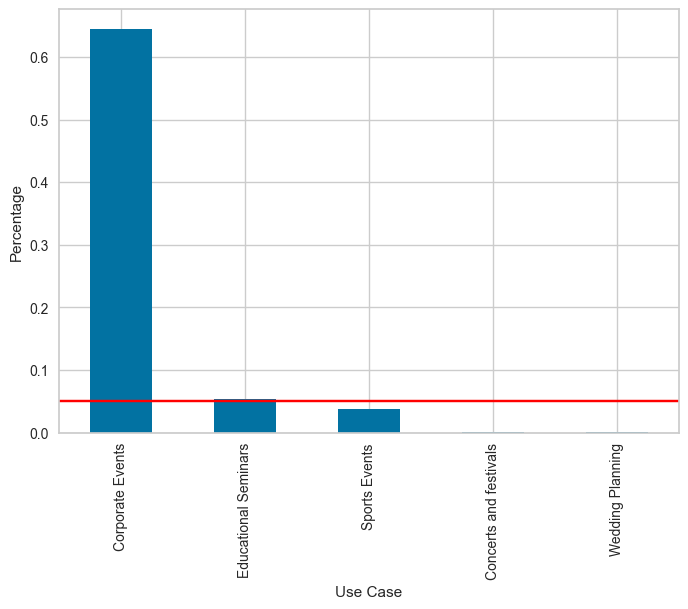

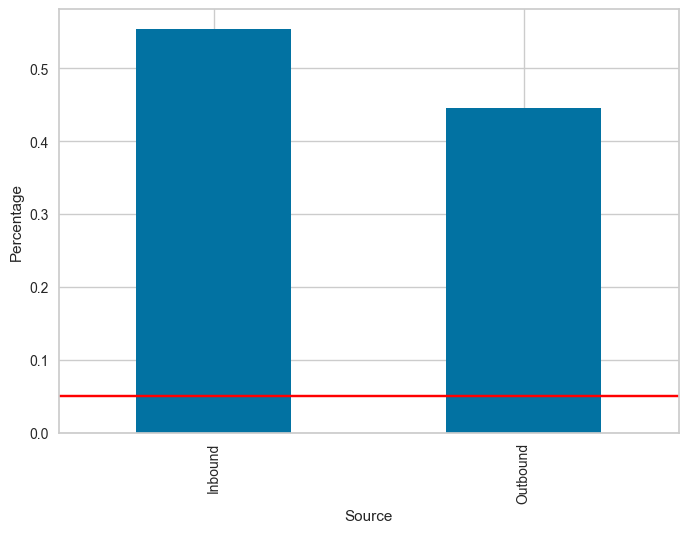

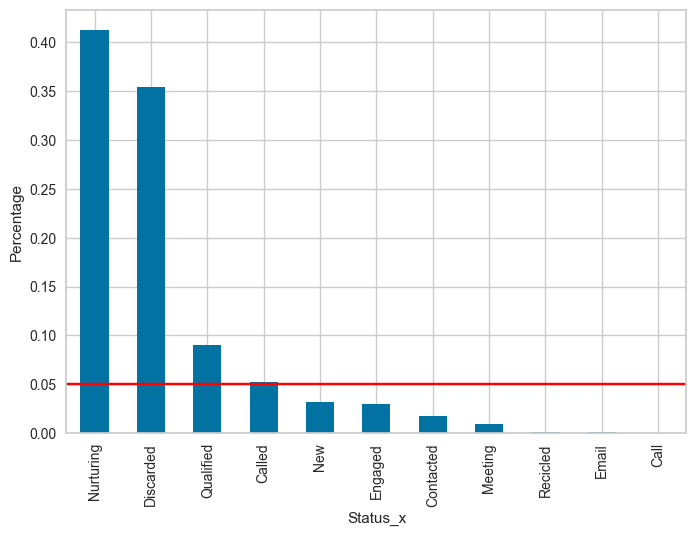

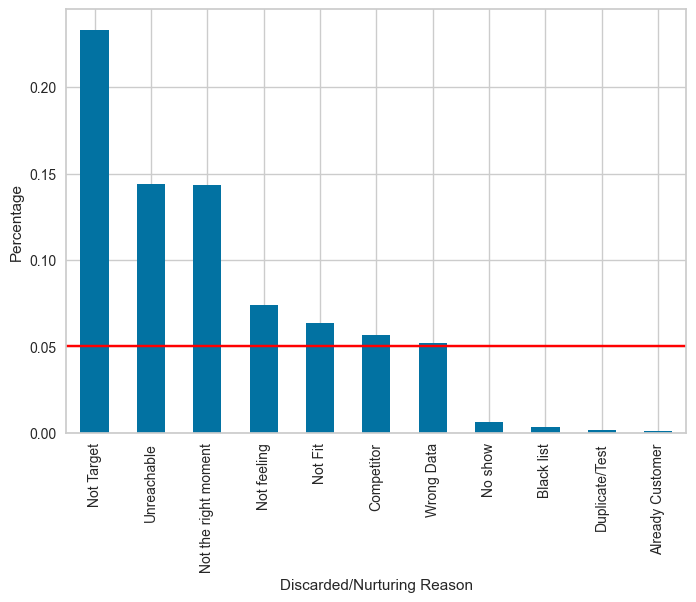

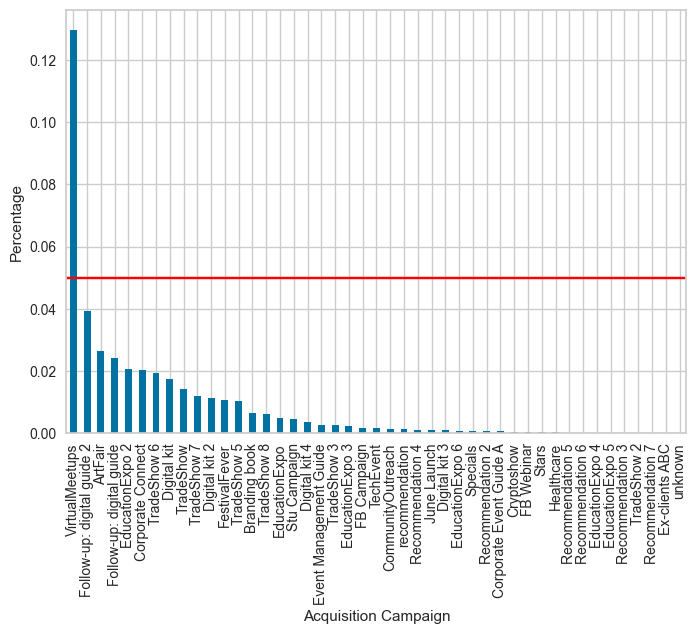

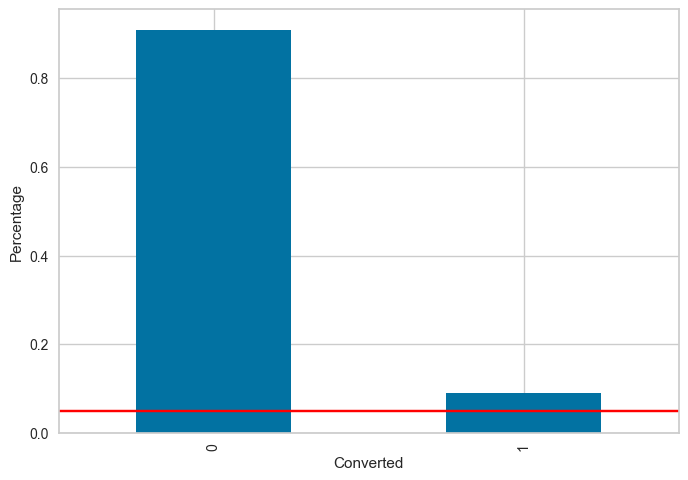

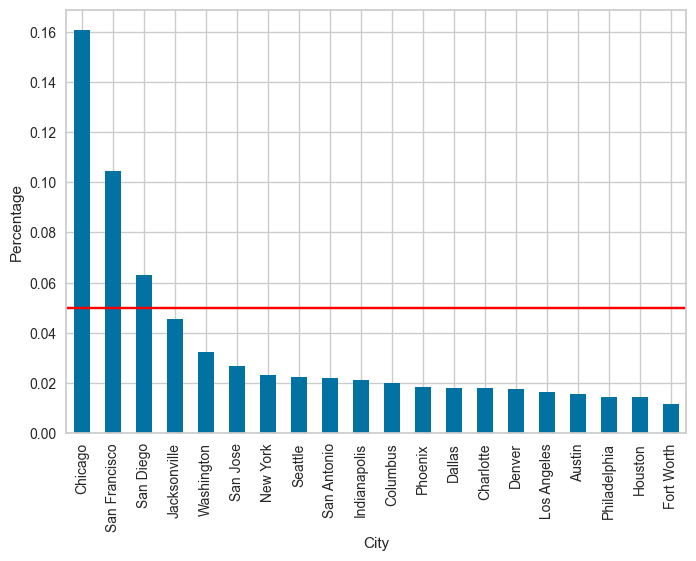

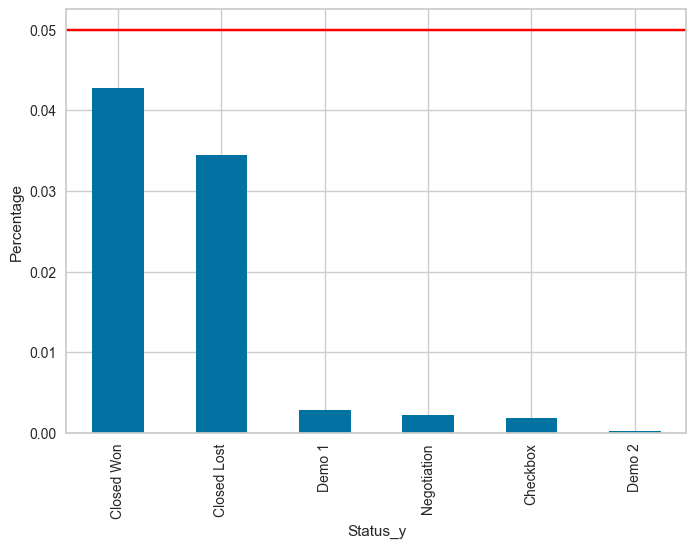

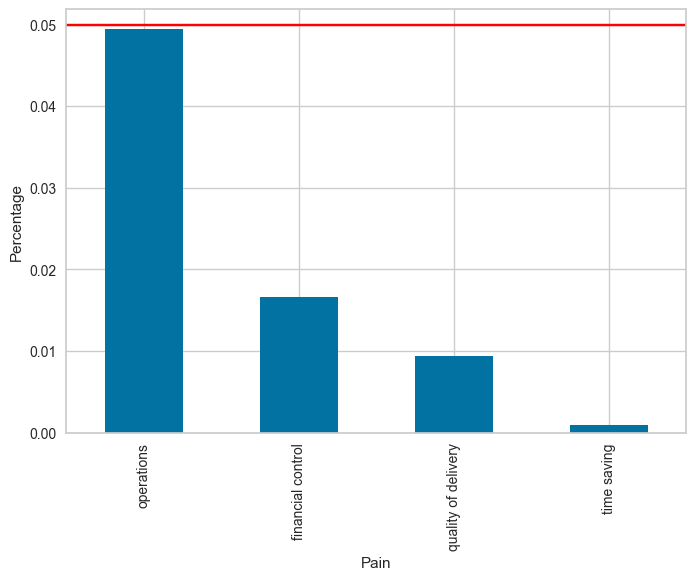

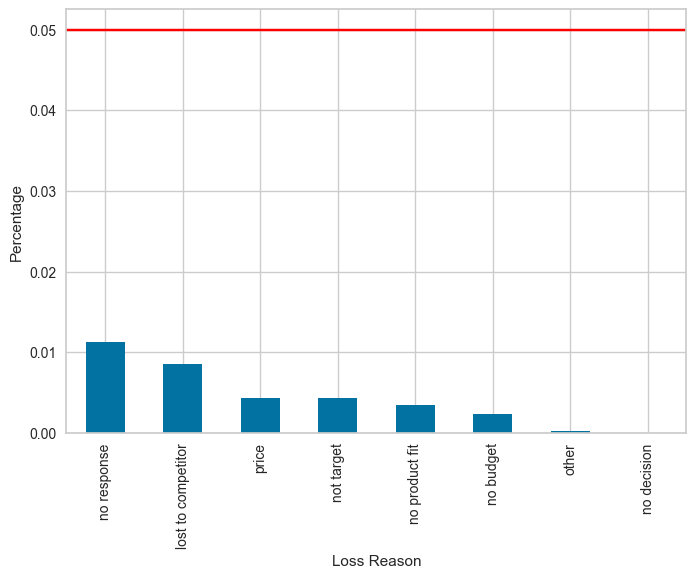

In [229]:
for col in ['Use Case', 'Source', 'Status_x',
       'Discarded/Nurturing Reason', 'Acquisition Campaign', 'Converted', 'City', 'Status_y',
       'Pain', 'Loss Reason']:

    temp_df = pd.Series(df[col].value_counts() / len(df))

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color="red")
    fig.set_ylabel("Percentage")
    plt.show()

In [230]:
#Use case
df['Use Case'] = df['Use Case'].fillna('Others')

use_case_mapping = {
    'Concerts and festivals': 'Others',
    'Wedding Planning': 'Others'
}
df['Use Case'] = df['Use Case'].replace(use_case_mapping)

#Source
source_distribution = df['Source'].value_counts(dropna=False, normalize=True)
df['Source'].fillna(pd.Series(np.random.choice(source_distribution.index, p=source_distribution.values, size=len(df))), inplace=True)

#Status
df = df.rename(columns={'Status_x': 'Status'})
df.loc[df['Status'] == 'Qualified', 'Status'] = df['Status_y']

status_mapping = {
    'Called': 'Contacted',
    'Meeting': 'Contacted',
    'Recicled': 'Contacted',
    'Email': 'Contacted',
    'Call': 'Contacted',
    'Demo 1': 'Offer',
    'Demo 2': 'Offer',
    'Negotiation': 'Offer', 
    'Checkbox': 'Offer',
    'New': 'Contacted',
    'Closed Won': 'Offer',
    'Closed Lost': 'Offer'
}

df['Status'] = df['Status'].replace(status_mapping)
df['Status'] = df['Status'].fillna('Other')


#Reason 
df = df.rename(columns={'Discarded/Nurturing Reason': 'Reason'})

def custom_logic(row):
    # if pd.isna(row['Reason']) and row['Status_y'] != 'Closed Won':
    #     loss_reason = row['Loss Reason'] if pd.notna(row['Loss Reason']) else 'Unknown'
    #     return 'loss at end'
    # elif row['Status_y'] == 'Closed Won':
    #     return 'Success'
    if pd.isna(row['Reason']) and (row['Status_y'] == 'Closed Won' or row['Status_y'] == 'Closed Lost'):
        return 'lead converted'
    else:
        return row['Reason']
df['Reason'] = df.apply(custom_logic, axis=1)


reason_mapping = {
    'Unreachable': 'Unreachable',
    'No show': 'Unreachable',
    'Not the right moment': 'Not fit',
    'Not feeling': 'Not fit',
    'Not Fit': 'Not fit',
    'Competitor': 'Not Target',
    'Wrong Data': 'Not Target',
    'Black list': 'Not Target',
    'Duplicate/Test': 'Not Target',
    'Already Customer': 'Not Target'
}
df['Reason'] = df['Reason'].replace(reason_mapping)
df['Reason'] = df['Reason'].fillna('Other')

#Acquisition Campaign
df['Acquisition Campaign'] = df['Acquisition Campaign'].notna().astype(int)

#City
region_mapping = {
    'Chicago': 'Midwest',
    'San Francisco': 'West',
    'San Diego': 'West',
    'Jacksonville': 'South',
    'Washington': 'East',
    'San Jose': 'West',
    'New York': 'Northeast',
    'Seattle': 'West',
    'San Antonio': 'South',
    'Indianapolis': 'Midwest',
    'Columbus': 'Midwest',
    'Phoenix': 'West',
    'Dallas': 'South',
    'Charlotte': 'South',
    'Denver': 'West',
    'Los Angeles': 'West',
    'Austin': 'South',
    'Philadelphia': 'Northeast',
    'Houston': 'South',
    'Fort Worth': 'South',
    
}
df['Region'] = df['City'].map(region_mapping)
df['Region'] = df['Region'].fillna('Unknown')


#Time to Offer
df['Created Date_x'] = pd.to_datetime(df['Created Date_x'])
df['Created Date_y'] = pd.to_datetime(df['Created Date_y'])
df['Time to Offer'] = np.where(
    (df['Created Date_y'] - df['Created Date_x']).dt.days >= 0,
    (df['Created Date_y'] - df['Created Date_x']).dt.days,
    0
)
df['Time to Offer'] = df['Time to Offer'].fillna(0)

#Time to Close
df['Close Date'] = pd.to_datetime(df['Close Date'])
df['Time to Close'] = np.where(
    (df['Close Date'] - df['Created Date_y']).dt.days >= 0,
    (df['Close Date'] - df['Created Date_y']).dt.days,
    df['Time to Offer']
)
df['Time to Close'] = df['Time to Close'].fillna(0)

#Price
df['Price'] = df['Price'].fillna(0)

#Discount Code
df['Discount code'] = df['Discount code'].notna().astype(int)

#Pain
df['Pain'] = df['Pain'].fillna('Not applicable')

#Target
df['Target'] = (df['Status_y'] == 'Closed Won').astype(int)

In [231]:
df = df[['Use Case', 'Source', 'Status', 'Reason', 'Acquisition Campaign', 'Converted',
         'Price', 'Discount code', 'Pain', 'Region', 'Time to Offer', 'Time to Close', 'Target']]
df.head()

,Use Case,Source,Status,Reason,Acquisition Campaign,Converted,Price,Discount code,Pain,Region,Time to Offer,Time to Close,Target
0,Corporate Events,Inbound,Nurturing,Not fit,0,0,0.0,0,Not applicable,Midwest,0.0,0.0,0
1,Others,Inbound,Nurturing,Not Target,0,0,0.0,0,Not applicable,West,0.0,0.0,0
2,Corporate Events,Inbound,Discarded,Not Target,0,0,0.0,0,Not applicable,Unknown,0.0,0.0,0
3,Others,Inbound,Nurturing,Not fit,0,0,0.0,0,Not applicable,Unknown,0.0,0.0,0
4,Others,Inbound,Nurturing,Not fit,0,0,0.0,0,Not applicable,West,0.0,0.0,0


In [232]:
df.Target.value_counts()

0    42102
1     1882
Name: Target, dtype: int64

In [233]:
output_directory = '../data_output/'
df.to_parquet(os.path.join(output_directory, 'final_dataset.parquet'))

### Modelo Logit con Pycaret

In [234]:
df[df.Target==1]

,Use Case,Source,Status,Reason,Acquisition Campaign,Converted,Price,Discount code,Pain,Region,Time to Offer,Time to Close,Target
33,Sports Events,Inbound,Offer,lead converted,0,1,240.0,1,operations,Midwest,4.0,0.0,1
70,Corporate Events,Inbound,Offer,lead converted,0,1,32396.0,1,quality of delivery,West,160.0,0.0,1
98,Corporate Events,Outbound,Offer,lead converted,0,1,450.0,1,operations,Midwest,181.0,62.0,1
101,Corporate Events,Inbound,Offer,lead converted,0,1,240.0,1,operations,East,0.0,31.0,1
112,Corporate Events,Inbound,Offer,lead converted,0,1,450.0,1,operations,Midwest,212.0,31.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43615,Corporate Events,Inbound,Offer,lead converted,0,1,240.0,1,Not applicable,Midwest,0.0,0.0,1
43681,Corporate Events,Outbound,Offer,lead converted,0,1,240.0,1,quality of delivery,Unknown,30.0,0.0,1
43760,Corporate Events,Inbound,Offer,lead converted,0,1,768.0,1,operations,Unknown,31.0,0.0,1
43812,Sports Events,Inbound,Offer,lead converted,1,1,240.0,1,operations,Unknown,0.0,0.0,1


In [235]:
s = setup(df, target = 'Target', session_id = 123, fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Binary
3,Original data shape,"(43984, 13)"
4,Transformed data shape,"(72138, 34)"
5,Transformed train set shape,"(58942, 34)"
6,Transformed test set shape,"(13196, 34)"
7,Ordinal features,1
8,Numeric features,6
9,Categorical features,6


In [262]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:21:06
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9854,0.9963,0.8671,0.8084,0.8360,0.8283,0.8293,0.6960
gbc,Gradient Boosting Classifier,0.9842,0.9963,0.9423,0.7526,0.8365,0.8283,0.8343,2.5490
rf,Random Forest Classifier,0.9841,0.9953,0.8564,0.7911,0.8219,0.8136,0.8146,0.9500
ada,Ada Boost Classifier,0.9829,0.9961,0.9438,0.7339,0.8252,0.8164,0.8238,0.9560
et,Extra Trees Classifier,0.9826,0.9894,0.8390,0.7742,0.8050,0.7959,0.7968,0.8410
lda,Linear Discriminant Analysis,0.9817,0.9923,0.9878,0.7051,0.8225,0.8131,0.8262,0.2590
ridge,Ridge Classifier,0.9816,0.0000,0.9878,0.7043,0.8219,0.8126,0.8257,0.1870
lr,Logistic Regression,0.9803,0.9937,0.9833,0.6899,0.8106,0.8006,0.8147,1.4020
dt,Decision Tree Classifier,0.9803,0.8869,0.7677,0.7718,0.7695,0.7592,0.7594,0.1950
knn,K Neighbors Classifier,0.9716,0.9835,0.9590,0.6073,0.7435,0.7294,0.7508,1.1300


In [263]:
print(best)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [264]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

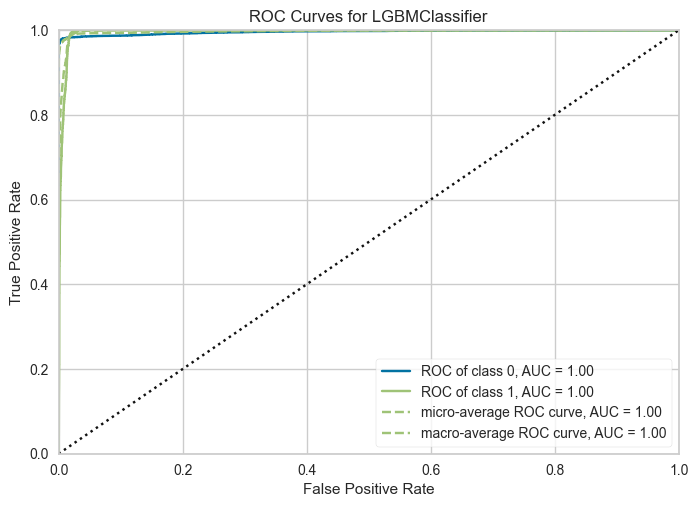

In [265]:
plot_model(best, plot = 'auc')

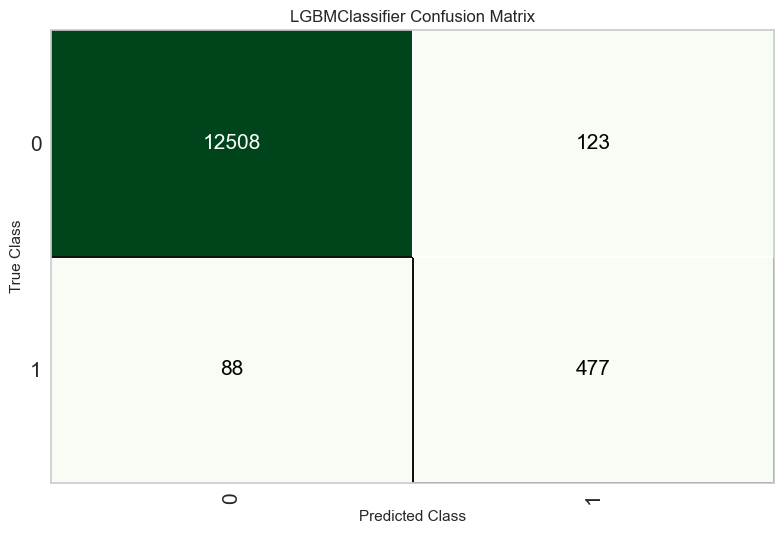

In [266]:
plot_model(best, plot = 'confusion_matrix')

In [267]:
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9840,0.9959,0.8442,0.7950,0.8189,0.8105,0.8109


,Use Case,Source,Status,Reason,Acquisition Campaign,Converted,Price,Discount code,Pain,Region,Time to Offer,Time to Close,Target,prediction_label,prediction_score
37742,Corporate Events,Outbound,Nurturing,Not fit,1,0,0.0,0,Not applicable,South,0.0,0.0,0,0,1.0000
38696,Corporate Events,Inbound,Nurturing,Not fit,0,0,0.0,0,Not applicable,Unknown,0.0,0.0,0,0,1.0000
13282,Corporate Events,Inbound,Discarded,Not Target,0,0,0.0,0,Not applicable,West,0.0,0.0,0,0,1.0000
42344,Corporate Events,Outbound,Contacted,Other,1,0,0.0,0,Not applicable,Unknown,0.0,0.0,0,0,1.0000
41072,Others,Outbound,Discarded,Not Target,1,0,0.0,0,Not applicable,East,0.0,0.0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9369,Educational Seminars,Inbound,Offer,lead converted,0,1,600.0,1,financial control,Unknown,61.0,0.0,1,0,0.5790
14089,Corporate Events,Inbound,Offer,lead converted,0,1,200.0,1,Not applicable,Unknown,1.0,1.0,0,1,0.6505
32018,Others,Outbound,Nurturing,Not fit,1,0,0.0,0,Not applicable,West,0.0,0.0,0,0,1.0000
4266,Corporate Events,Inbound,Nurturing,Not fit,0,0,0.0,0,Not applicable,Unknown,0.0,0.0,0,0,1.0000


In [268]:
save_model(best, 'model_pycaret')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Acquisition Campaign',
                                              'Converted', 'Price',
                                              'Discount code', 'Time to Offer',
                                              'Time to Close'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),...
      

### Modelo Logit con Scikit-Learn

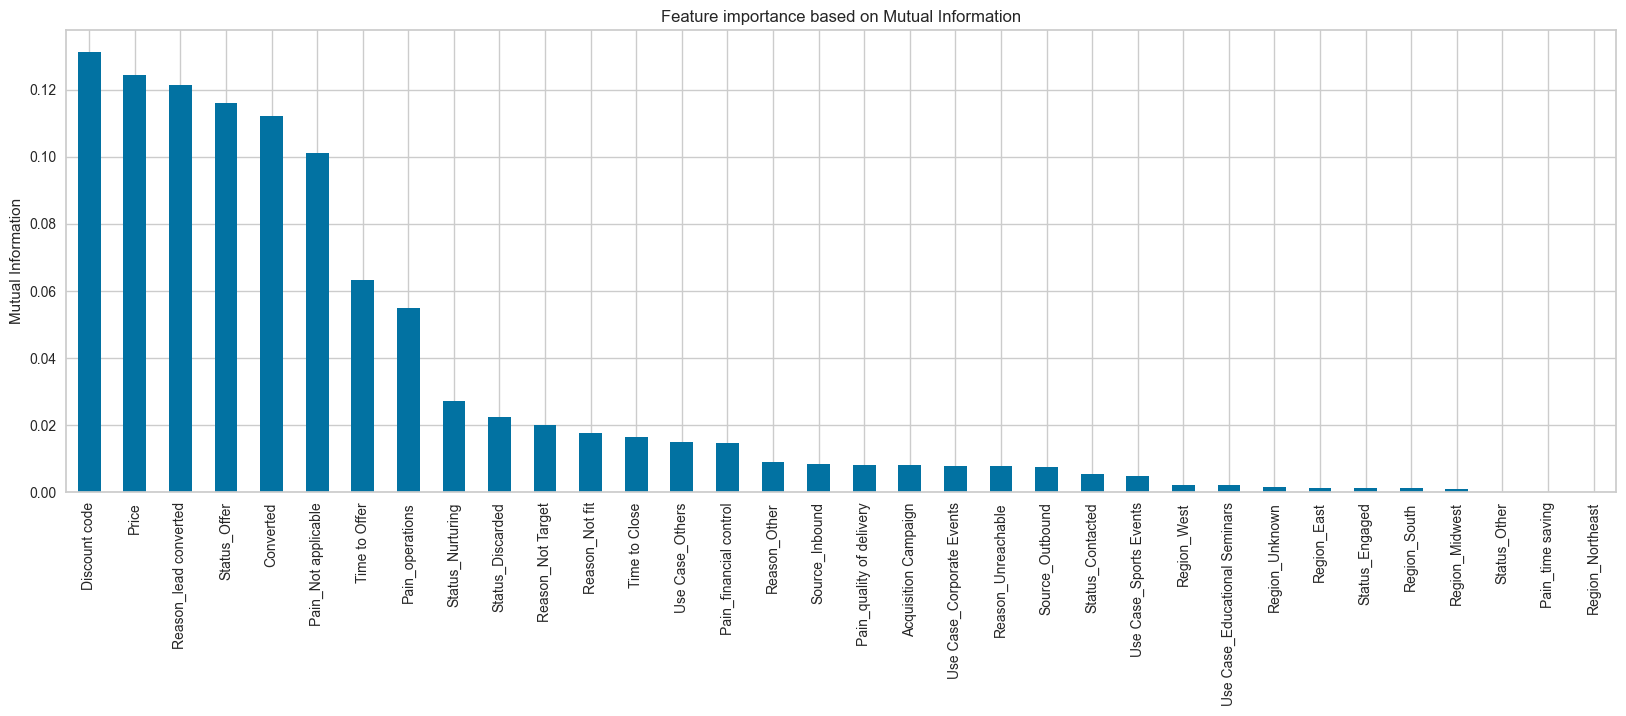

In [243]:
X = df.drop(labels=['Target'], axis=1)
y = df['Target']

X_encoded = pd.get_dummies(X)

mi = mutual_info_classif(X_encoded, y)

mi = pd.Series(mi, index=X_encoded.columns)

mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.title('Feature importance based on Mutual Information')
plt.ylabel('Mutual Information')
plt.show()

Text(0.5, 1.0, 'Feature importance based on chi-square test')

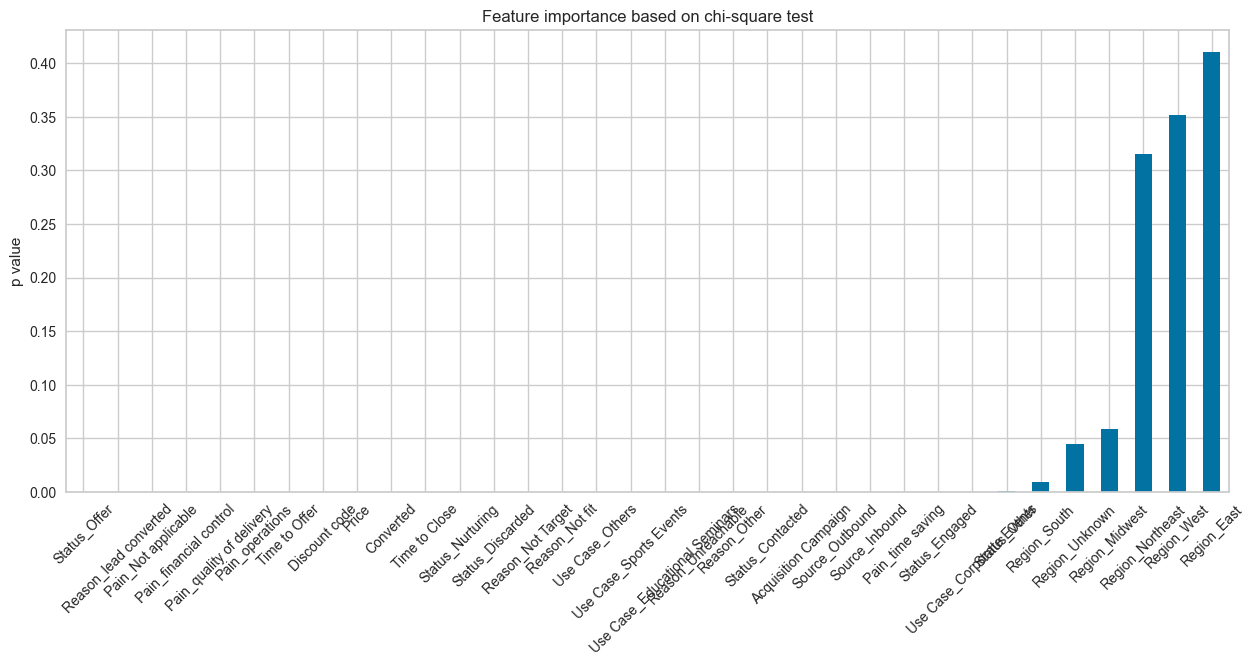

In [244]:
chi_ls = []

for feature in X_encoded.columns:
    
    # create contingency table
    c = pd.crosstab(y, X_encoded[feature])
    
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

plt.figure(figsize=(15, 6))
pd.Series(chi_ls, index=X_encoded.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [245]:
categorical_cols = df.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Target', axis=1), df_model['Target'], test_size=0.2, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [246]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35187, 28) (8797, 28) (35187,) (8797,)


Matriz de Confusión:
[[8345   94]
 [  64  294]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8439
           1       0.76      0.82      0.79       358

    accuracy                           0.98      8797
   macro avg       0.88      0.91      0.89      8797
weighted avg       0.98      0.98      0.98      8797


ROC AUC Score: 0.9930761740019238


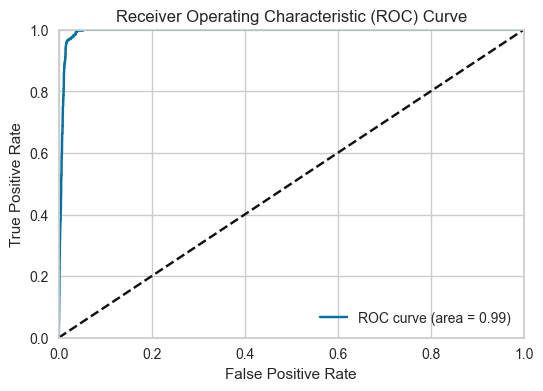

In [247]:
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))


fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Matriz de confusión:
[[8345   94]
 [  64  294]]


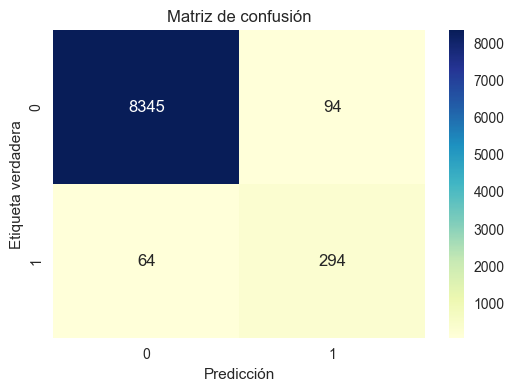

In [248]:
confusion = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(confusion)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión')
plt.show()

In [249]:
y_probs = logreg.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

X_test_limited = X_test.iloc[:8797].reset_index(drop=True)
formatted_probs = [f'{prob:.3f}' for prob in y_probs]
results_df = pd.DataFrame({
        'Predicted Probability': formatted_probs,
        'Predictiom': logreg.predict(X_test_limited),
        'True Label': y_test,
        **X_test_limited.to_dict(orient='list')  # Agrega las demás columnas
    })

results_df

,Predicted Probability,Predictiom,True Label,Acquisition Campaign,Converted,Price,Discount code,Time to Offer,Time to Close,Use Case_Educational Seminars,...,Reason_lead converted,Pain_financial control,Pain_operations,Pain_quality of delivery,Pain_time saving,Region_Midwest,Region_Northeast,Region_South,Region_Unknown,Region_West
10688,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
8147,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
19557,0.719,1,0,0,1,1008.0,1,0.0,0.0,0,...,1,0,1,0,0,1,0,0,0,0
2528,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
25779,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27232,0.000,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
27479,0.000,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
42753,0.001,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
19260,0.750,1,1,0,1,240.0,1,1.0,1.0,0,...,1,0,1,0,0,0,0,1,0,0


In [250]:
### guardar modelo
with open('../models_binary/Logit_scikitlearn.pkl', 'wb') as file:
    pickle.dump(logreg, file)

In [251]:
def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    print(classification_report(y_test,prediction, digits=4))

### Modelo Random Forest con Scikit Learn

In [252]:
sfs = SFS(
    estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
    n_features_to_select=10,  # the number of features to retain
    tol=None,  # the maximum increase or decrease in the performance metric
    direction='forward',  # the direction of the selection procedure
    scoring='roc_auc',  # the metric to evaluate
    cv=2,  # the cross-validation fold
    n_jobs=4,  # for parallelization
)

sfs = sfs.fit(X_train, y_train)

In [253]:
selected_feat = sfs.get_feature_names_out()

selected_feat

array(['Discount code', 'Use Case_Educational Seminars',
       'Status_Discarded', 'Status_Offer', 'Status_Other',
       'Reason_Not fit', 'Reason_Other', 'Reason_Unreachable',
       'Reason_lead converted', 'Pain_operations'], dtype=object)

In [254]:

# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [255]:
# evaluate performance of algorithm built
# using selected features

run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9921038312974446
Test set
Random Forests roc-auc: 0.9912320160256219


In [256]:
# and for comparison, we train random forests using
# all features 
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9968650012011132
Test set
Random Forests roc-auc: 0.9955616415140929


In [257]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=40, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9838581334545868
Precision: 0.7887700534759359
Recall: 0.8240223463687151
F1 Score: 0.8060109289617488


              precision    recall  f1-score   support

           0     0.9925    0.9906    0.9916      8439
           1     0.7888    0.8240    0.8060       358

    accuracy                         0.9839      8797
   macro avg     0.8906    0.9073    0.8988      8797
weighted avg     0.9842    0.9839    0.9840      8797

Matriz de Confusión:
[[8360   79]
 [  63  295]]


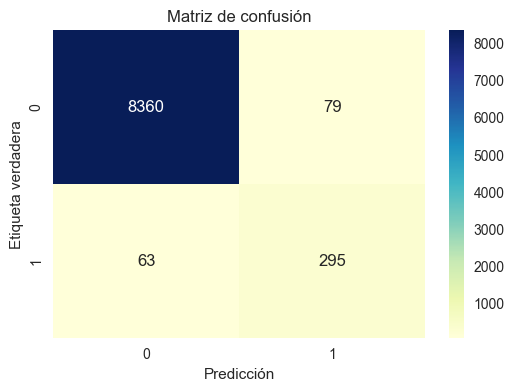


ROC AUC Score: 0.9956511766002618


In [258]:
feature_importances = model.feature_importances_
features = X_train.columns

df_importancia = pd.DataFrame({'Variable': features, 'Importancia': feature_importances})
df_importancia.sort_values(by='Importancia', ascending = False)

report = classification_report(y_test, y_pred, digits=4)
print(report)


def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d")
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta verdadera')
    plt.title('Matriz de confusión')

    print("Matriz de Confusión:")
    print(conf_matrix)

    plt.show()

plot_confusion_matrix(y_test, y_pred)

print("\nROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

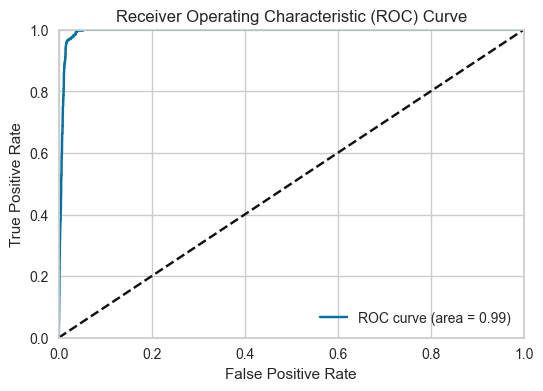

In [259]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [260]:
y_probs = logreg.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

X_test_limited = X_test.iloc[:8797].reset_index(drop=True)
formatted_probs = [f'{prob:.3f}' for prob in y_probs]
results_df = pd.DataFrame({
        'Predicted Probability': formatted_probs,
        'Predictiom': logreg.predict(X_test_limited),
        'True Label': y_test,
        **X_test_limited.to_dict(orient='list')  # Agrega las demás columnas
    })

results_df

,Predicted Probability,Predictiom,True Label,Acquisition Campaign,Converted,Price,Discount code,Time to Offer,Time to Close,Use Case_Educational Seminars,...,Reason_lead converted,Pain_financial control,Pain_operations,Pain_quality of delivery,Pain_time saving,Region_Midwest,Region_Northeast,Region_South,Region_Unknown,Region_West
10688,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
8147,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
19557,0.719,1,0,0,1,1008.0,1,0.0,0.0,0,...,1,0,1,0,0,1,0,0,0,0
2528,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
25779,0.000,0,0,0,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27232,0.000,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
27479,0.000,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
42753,0.001,0,0,1,0,0.0,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
19260,0.750,1,1,0,1,240.0,1,1.0,1.0,0,...,1,0,1,0,0,0,0,1,0,0


In [261]:
### guardar modelo
with open('RandomForest_scikitlearn.pkl', 'wb') as file:
    pickle.dump(model, file)